In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from scipy import ndimage
from scipy import linalg
from skimage.util.shape import view_as_windows
import random
import math
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import io

In [2]:
# Read sample data.
img = Image.open('../sample_data/ImageSlice.png')
mask = Image.open('../sample_data/ImageMask.png')

In [3]:
# Turn image into a Numpy array.
img_array = np.array(img, dtype=np.uint8)
# Remove alpha channel.
#img_array = img_array[:, :, 0]
print(f'IMAGE:\nwidth={img_array.shape[0]} height={img_array.shape[1]}')

IMAGE:
width=440 height=596


In [4]:
# Create random window.
patch_window_size = random.randint(50, 150)
haralick_window_size = random.randint(5,20)
mask_center_x, mask_center_y = random.randint(patch_window_size, img_array.shape[1] - patch_window_size), random.randint(patch_window_size, img_array.shape[0] - patch_window_size)
print(f'WINDOW:\nCenter: x={mask_center_x} y={mask_center_y}; Size: width={patch_window_size} height={patch_window_size}')
mask_min_x = int(mask_center_x - patch_window_size/2)
mask_min_y = int(mask_center_y - patch_window_size/2)
mask_max_x = mask_min_x + patch_window_size
mask_max_y = mask_min_y + patch_window_size

WINDOW:
Center: x=458 y=231; Size: width=133 height=133


In [5]:
def show_colored_image(figure, axis, image_data, colormap=plt.cm.jet):
    image = axis.imshow(image_data, cmap=colormap)
    divider = make_axes_locatable(axis)
    colorbar_axis = divider.append_axes("right", size="5%", pad=0.05)
    figure.colorbar(image, cax=colorbar_axis)

def create_highlighted_rectangle(x, y, w, h):
    return Rectangle((x, y), w, h, linewidth=3, edgecolor='cyan', facecolor='none')

def highlight_rectangle_on_image(image_data, min_x, min_y, w, h, colormap=plt.cm.gray):
    figure, axes = plt.subplots(1,2, figsize=(15,15))

    # Highlight window within image.
    show_colored_image(figure, axes[0], image_data, colormap)
    axes[0].add_patch(create_highlighted_rectangle(min_x, min_y, w, h))

    # Crop window.
    cropped_array = image_data[min_y:min_y+h, min_x:min_x+w]
    axes[1].set_title('Cropped Region')
    show_colored_image(figure, axes[1], cropped_array, colormap)
    
    plt.show()
    
    return cropped_array

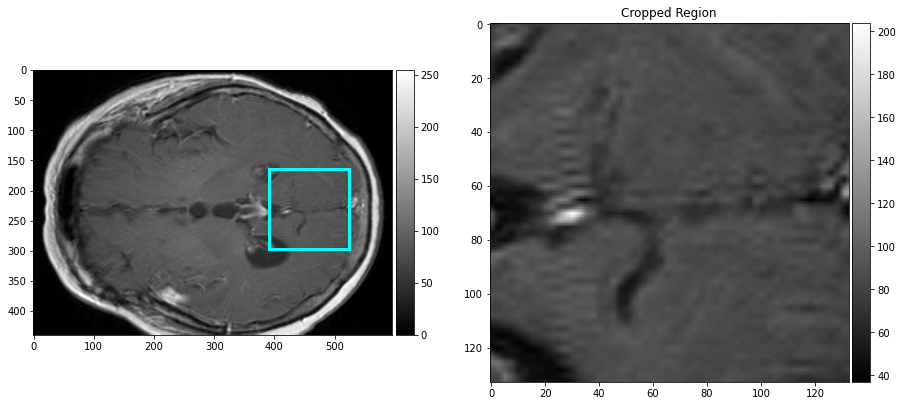

In [6]:
cropped_array = highlight_rectangle_on_image(img_array, mask_min_x, mask_min_y, patch_window_size, patch_window_size)

Text(0.5, 1.0, 'dy')

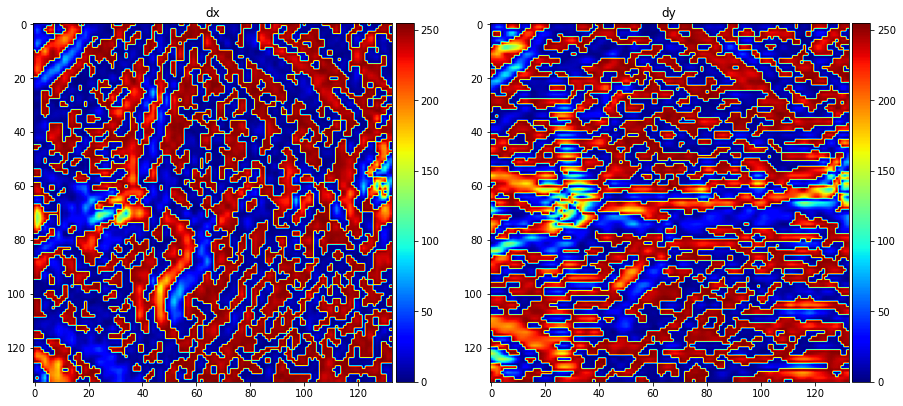

In [7]:
figure, axes = plt.subplots(1, 2, figsize=(15, 15))

# Define kernel for x differences.
kernel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

# Define kernel for y differences.
kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Perform x convolution.
dx=ndimage.convolve(cropped_array, kernel_x)

# Perform y convolution.
dy=ndimage.convolve(cropped_array, kernel_y)

# Display dx & dy.
show_colored_image(figure, axes[0], dx)
axes[0].set_title('dx')
show_colored_image(figure, axes[1], dy)
axes[1].set_title('dy')

Creating windows:
Creating windows done.
Center x,y = 65, 93
dx Patch for Haralick:


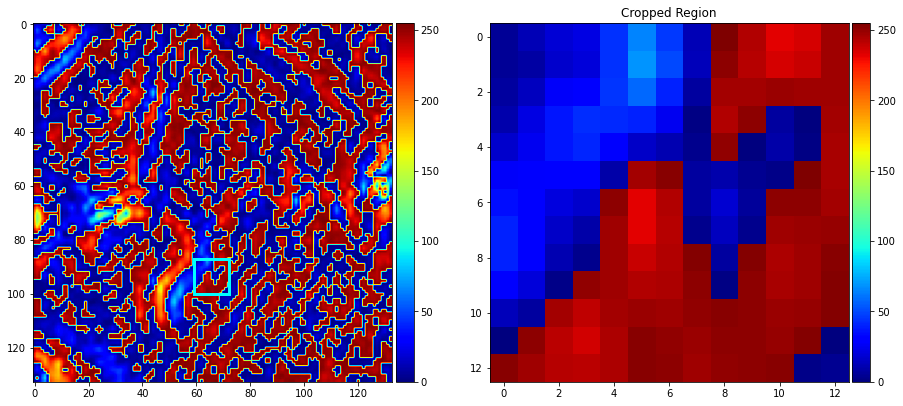

dy Patch for Haralick:


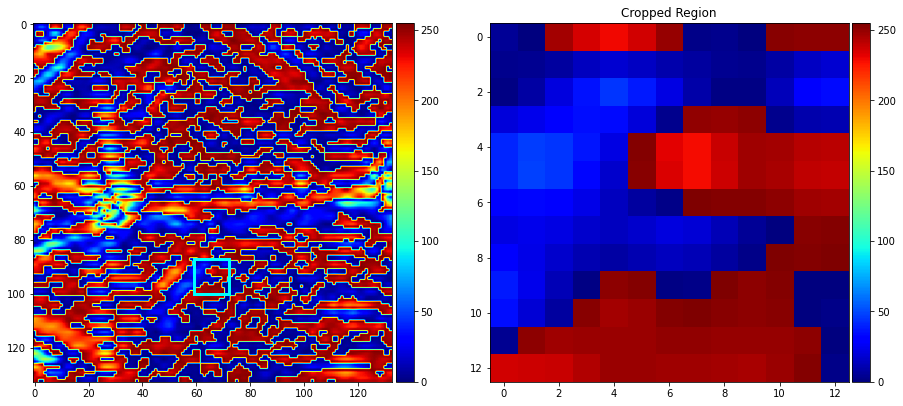

array([[  5,   0, 247, 236, 230, 237, 250,   2,   3,   0, 253, 252, 252],
       [  3,   4,   7,  14,  18,  15,  10,   7,   4,   3,   8,  15,  18],
       [  1,   8,  21,  36,  45,  38,  22,   9,   1,   1,  13,  28,  34],
       [ 20,  24,  29,  35,  34,  20,   3, 251, 250, 252,   3,  10,  11],
       [ 41,  47,  45,  37,  22, 254, 233, 229, 239, 248, 247, 243, 242],
       [ 41,  48,  45,  33,  17, 253, 235, 229, 238, 248, 246, 241, 240],
       [ 29,  33,  31,  23,  14,   7,   2, 255, 254, 254, 252, 248, 247],
       [ 22,  24,  22,  17,  14,  17,  21,  19,  12,   5,   0, 253, 254],
       [ 28,  23,  17,  11,   8,  11,  14,  12,   7,   2, 255, 254, 255],
       [ 38,  24,  12,   1, 252, 254,   1,   2, 255, 252, 254,   0,   0],
       [ 35,  19,   7, 253, 247, 249, 254, 255, 253, 252, 253,   0,   2],
       [  4, 252, 248, 249, 249, 249, 251, 251, 250, 250, 250, 252,   0],
       [237, 238, 239, 244, 249, 249, 248, 248, 247, 246, 249, 254,   2]],
      dtype=uint8)

In [8]:
# Create windows.
print('Creating windows:')
dx_windows = view_as_windows(dx, (haralick_window_size, haralick_window_size))
dy_windows = view_as_windows(dy, (haralick_window_size, haralick_window_size))
print('Creating windows done.')

# Extract a random patch
haralick_center_x = random.randint(int(haralick_window_size/2),dx.shape[1]-int(haralick_window_size/2))
haralick_center_y = random.randint(int(haralick_window_size/2),dx.shape[1]-int(haralick_window_size/2))

print(f'Center x,y = {haralick_center_x}, {haralick_center_y}')

# Get window at x,y.
dx_patch = dx_windows[haralick_center_y, haralick_center_x]
dy_patch = dy_windows[haralick_center_y, haralick_center_x]

# Display windows.
haralick_min_x = haralick_center_x - int(haralick_window_size/2)
haralick_min_y = haralick_center_y - int(haralick_window_size/2)
print('dx Patch for Haralick:')
highlight_rectangle_on_image(dx, haralick_min_x, haralick_min_y, haralick_window_size, haralick_window_size, plt.cm.jet)
print('dy Patch for Haralick:')
highlight_rectangle_on_image(dy, haralick_min_x, haralick_min_y, haralick_window_size, haralick_window_size, plt.cm.jet)

In [9]:
def svd_dominant_angle(x, y, dx_windows, dy_windows, window_size):
    dx_patch = dx_windows[y, x]
    dy_patch = dy_windows[y, x]
    window_area = window_size * window_size
    flattened_gradients = np.zeros((window_area, 2))
    #print(f'Flattened gradients shape = {flattened_gradients.shape}')
    flattened_gradients[:,0] = np.reshape(dx_patch, ((window_area)))
    flattened_gradients[:,1] = np.reshape(dy_patch, ((window_area)))
    #print('Calculating svd...', flush=True)
    U, S, V = linalg.svd(flattened_gradients)
    #print('Calculating svd done.', flush=True)
    #print(f'V (from SVD) = \n{V}')
    dominant_angle = math.atan2(V[0, 0], V[0, 1])
    #print(f'Dominant angle = atan2({V[0, 0]}/{V[0, 1]})={dominant_angle}')
    return dominant_angle

Calculating svd:
Calculating svd done.


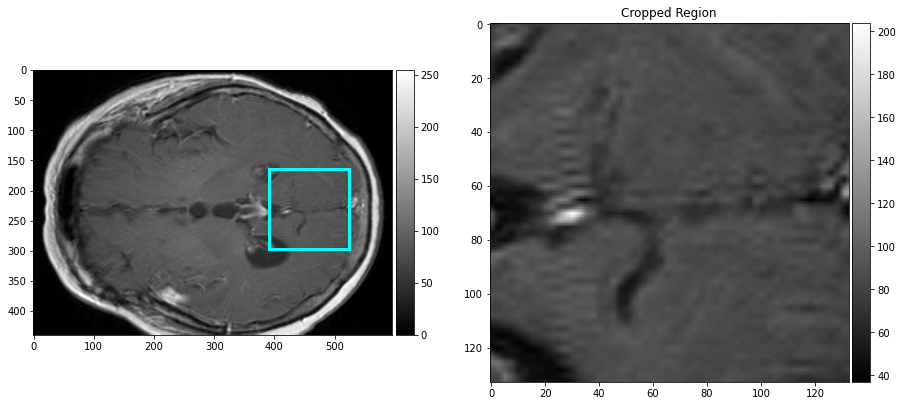

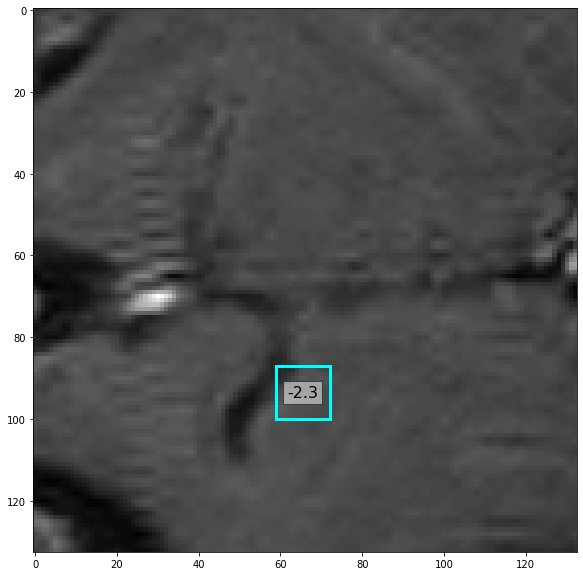

In [13]:
print('Calculating svd:')
dominant_angle = svd_dominant_angle(haralick_center_x, haralick_center_y, dx_windows, dy_windows, haralick_window_size)
print('Calculating svd done.')

# Show highlighted region.
highlight_rectangle_on_image(img_array, mask_min_x, mask_min_y, patch_window_size, patch_window_size)

# Overlay dominant angle on top of window.
figure, axis = plt.subplots(1, 1, figsize=(10, 10))
image_patch_array = img_array[mask_min_y:mask_max_y, mask_min_x:mask_max_x]
axis.imshow(image_patch_array, cmap=plt.cm.gray)
axis.add_patch(create_highlighted_rectangle(haralick_min_x, haralick_min_y, haralick_window_size, haralick_window_size))
axis.text(haralick_min_x + haralick_window_size / 2, haralick_min_y + haralick_window_size / 2, round(dominant_angle, 2), fontsize=16, horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

In [14]:
def show_arrow_on_window(window_array, center_x, center_y, window_size, dominant_angle):
    fig, ax = plt.subplots(1)
    ax.imshow(window_array, cmap=plt.cm.gray)
    arrow_dx = math.cos(dominant_angle) * window_size
    arrow_dy = math.sin(dominant_angle) * window_size * -1
    arrow_x = center_x
    arrow_y = center_y
    print(f'x={arrow_x} y={arrow_y} dx={arrow_dx} dy={arrow_dy}')
    arrow = mpatches.Arrow(arrow_x, arrow_y, arrow_dx, arrow_dy, width=5, color='orange')
    ax.add_patch(arrow)
    plt.show()

x=65 y=93 dx=-8.64134716380712 dy=9.71221494791804


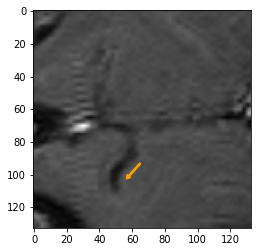

In [16]:
show_arrow_on_window(cropped_array, haralick_center_x, haralick_center_y, haralick_window_size, dominant_angle)